In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Flatten
from keras.layers import Conv1D, LSTM, Dropout, Bidirectional,LayerNormalization
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

df = pd.read_csv('./data/HAR/WISDM/WISDM.csv', index_col=0)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


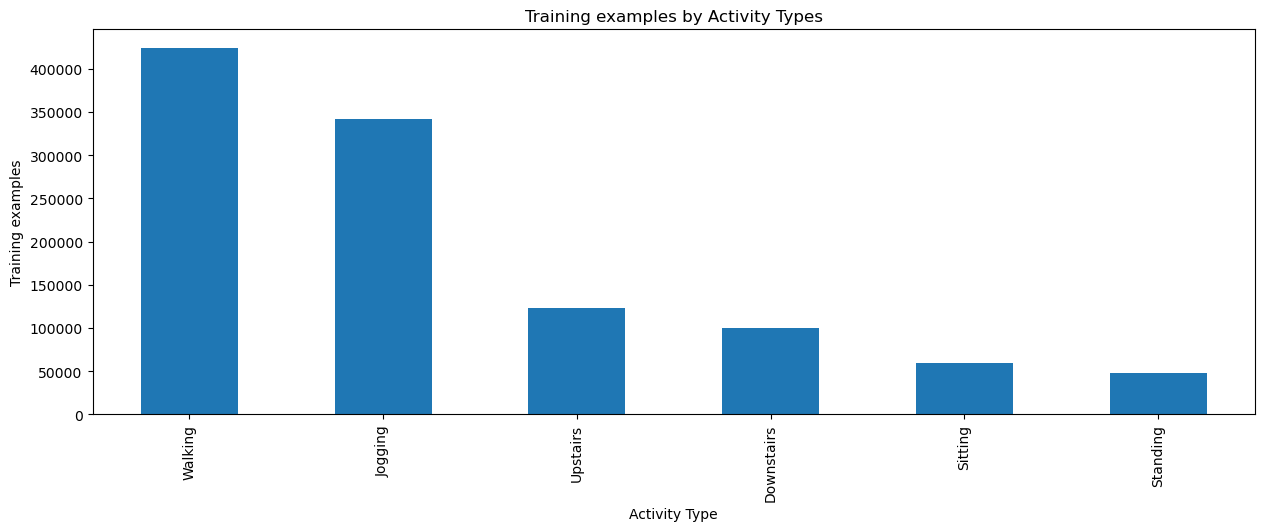

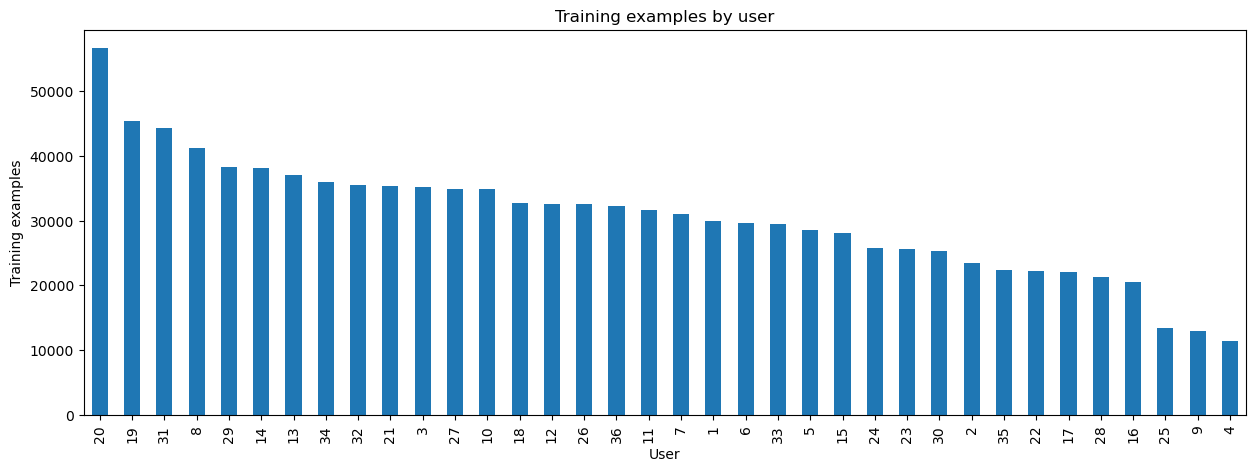

In [3]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar',
                                 title='Training examples by user')
plt.show()

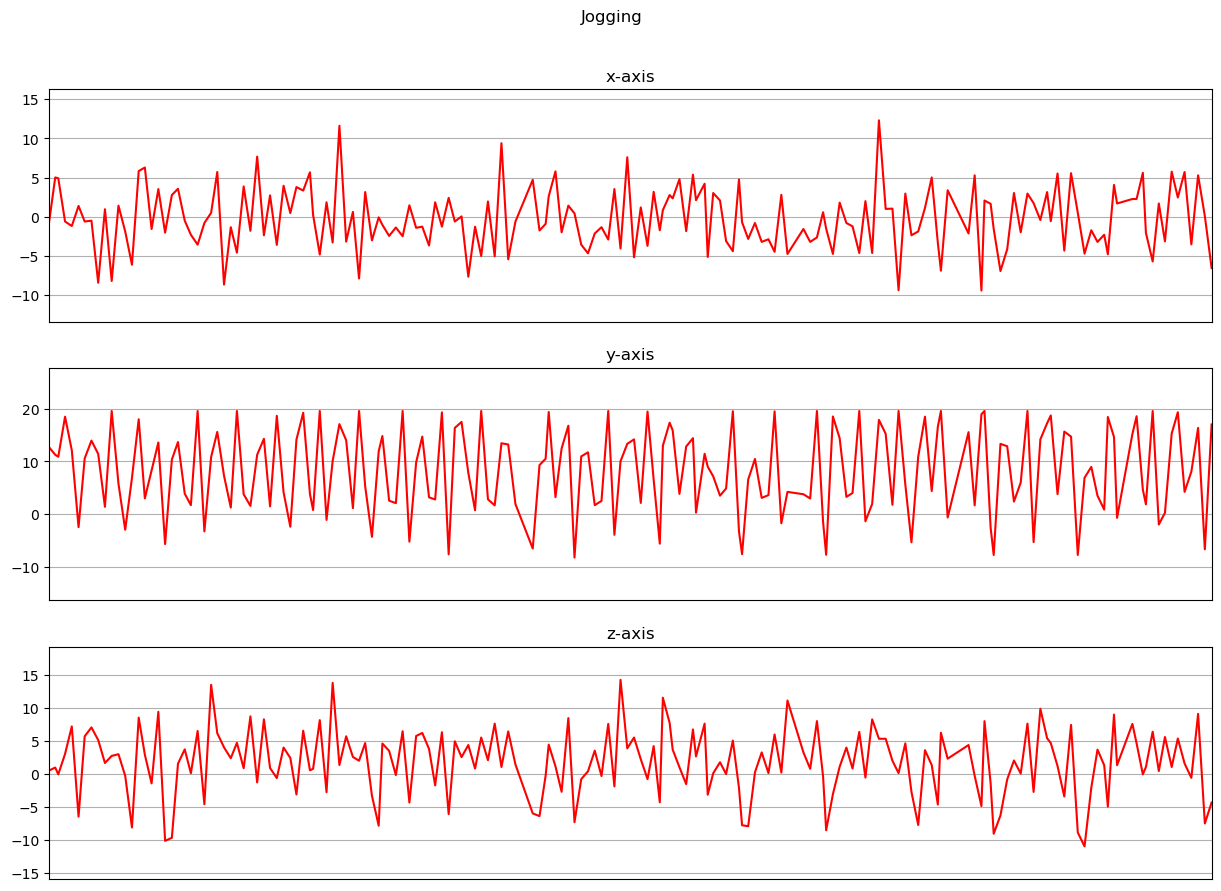

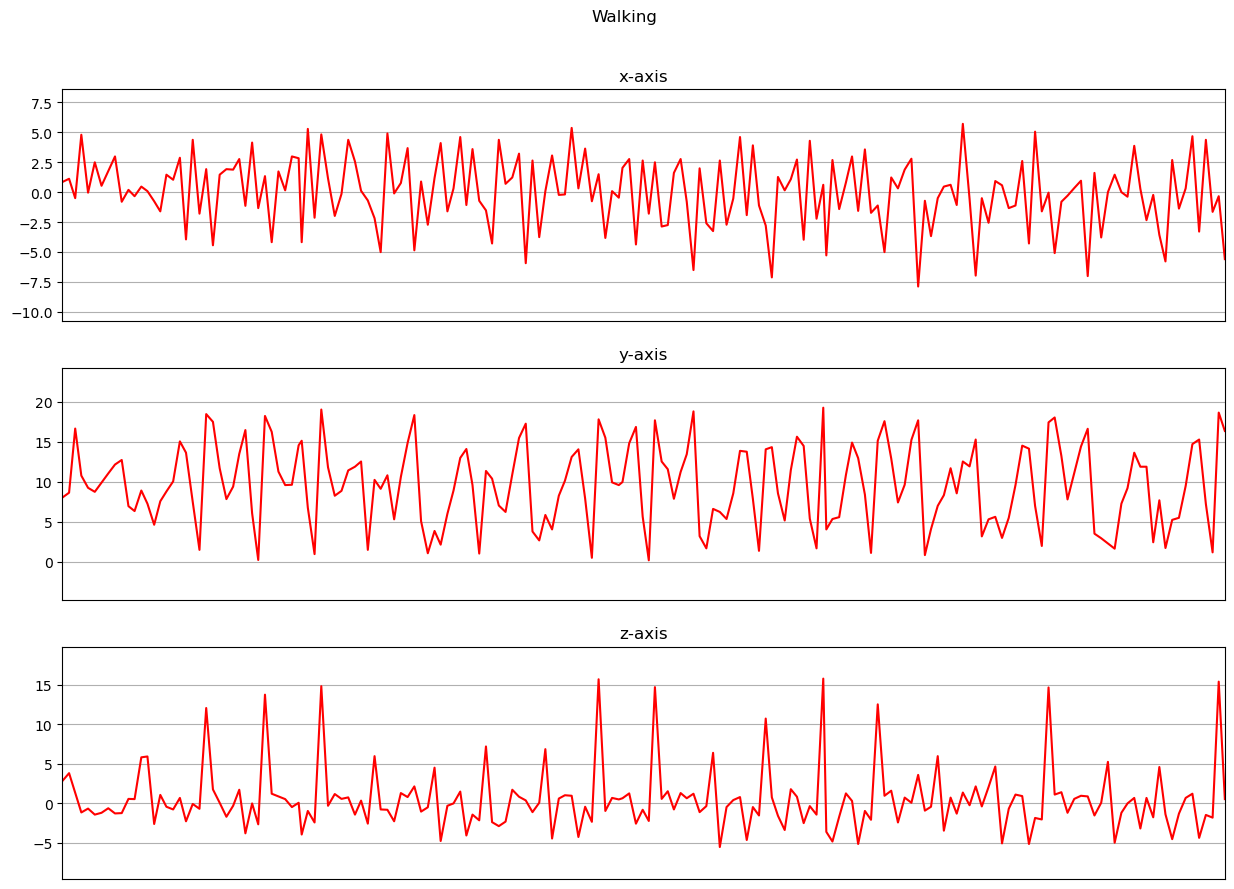

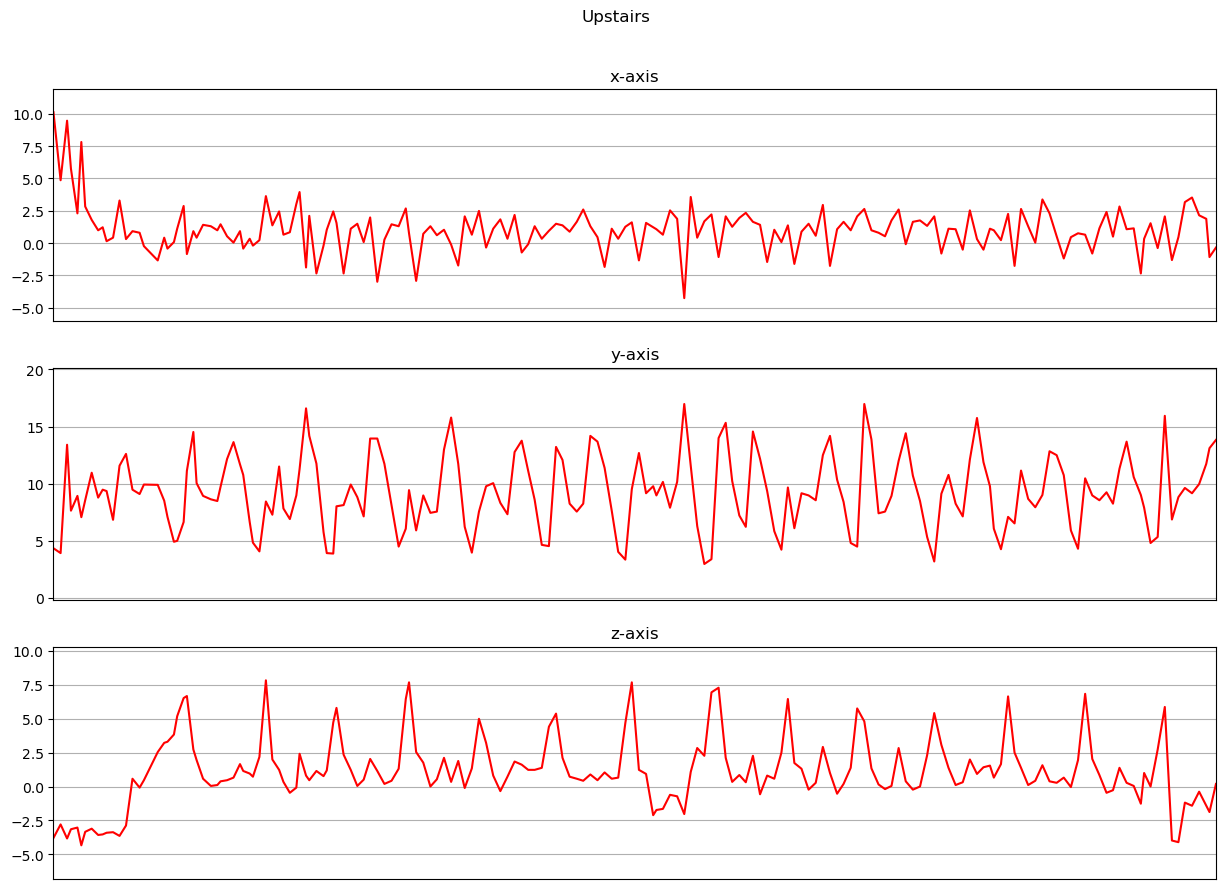

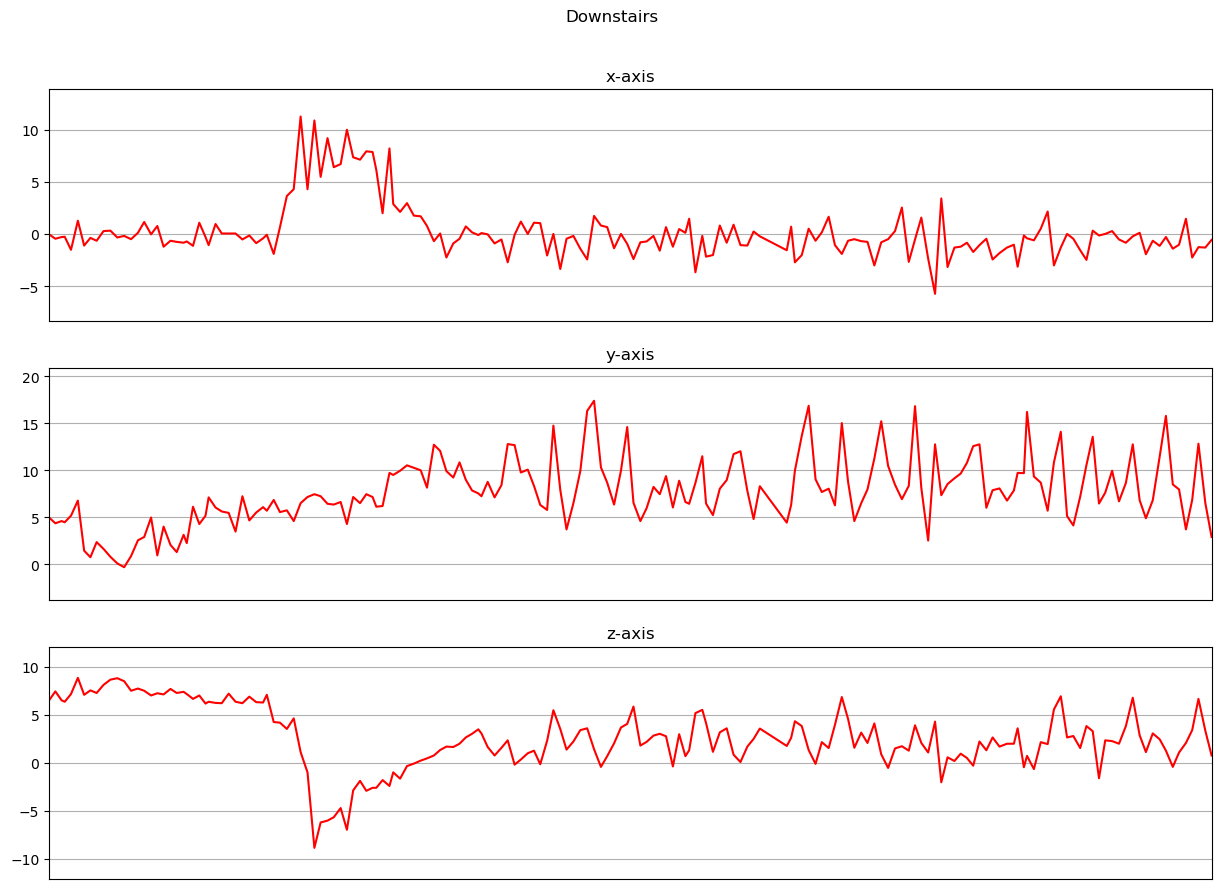

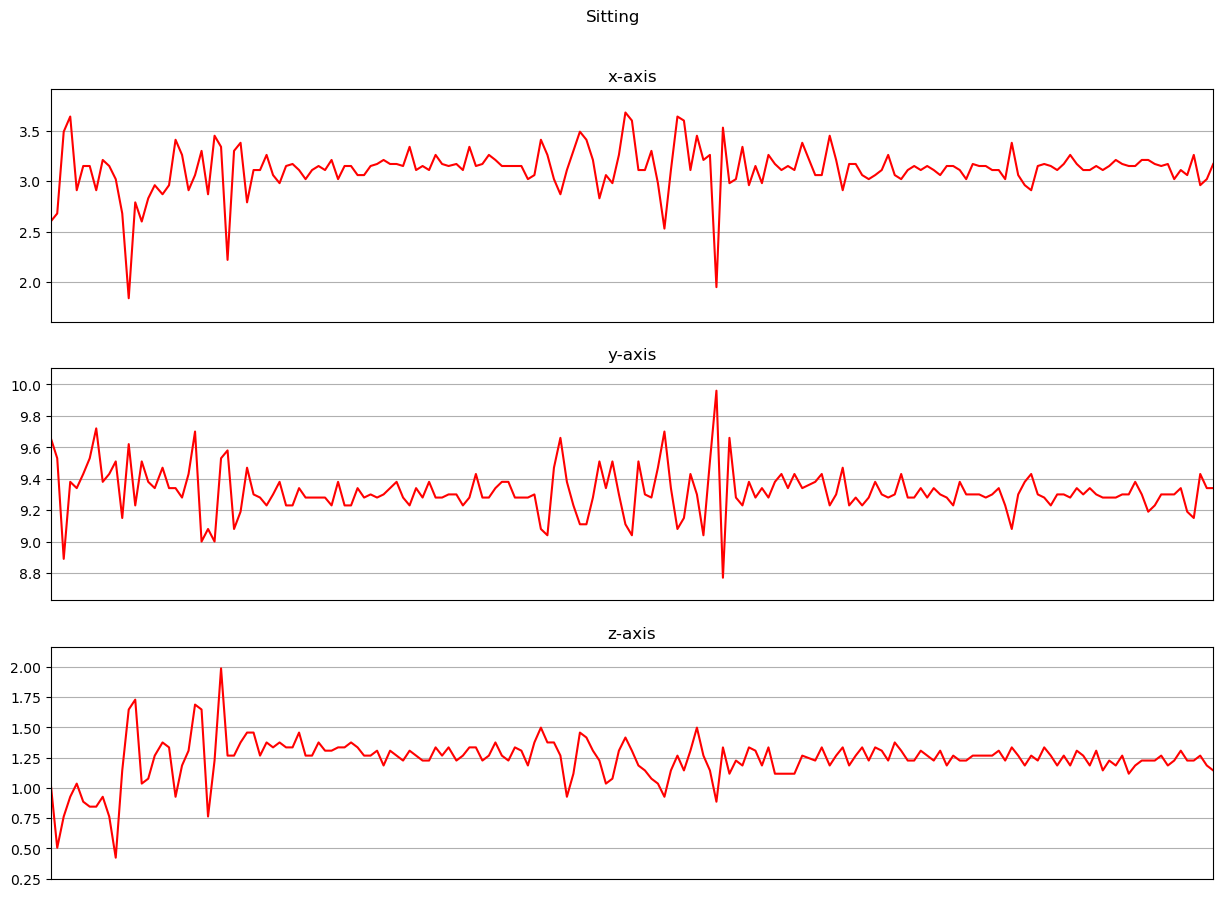

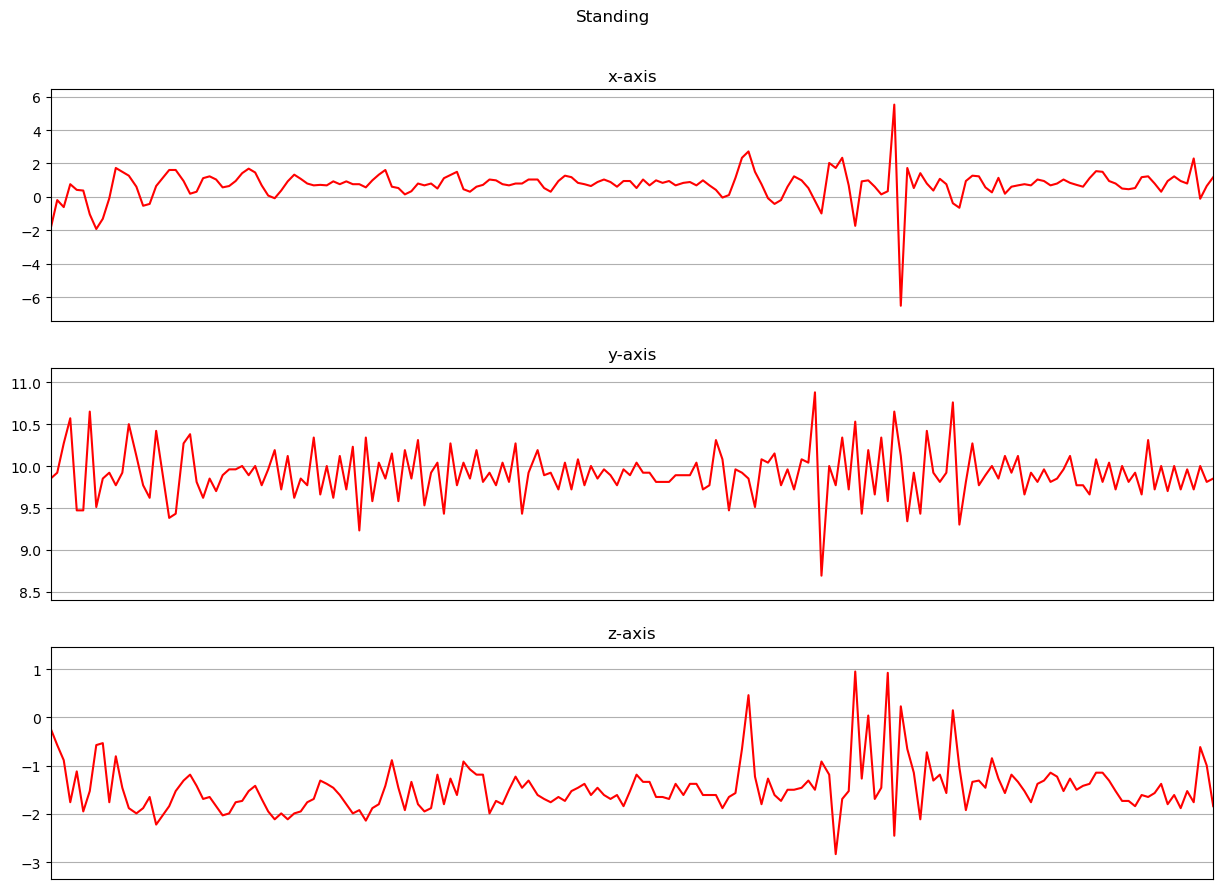

In [4]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [5]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user-id         1098203 non-null  int64  
 1   activity        1098203 non-null  object 
 2   timestamp       1098203 non-null  int64  
 3   X               1098203 non-null  float64
 4   Y               1098203 non-null  float64
 5   Z               1098203 non-null  float64
 6   activityEncode  1098203 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 62.8+ MB


In [31]:
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [32]:
from sklearn.preprocessing import MinMaxScaler

# df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
# df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
# df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())


scaler = MinMaxScaler()
df_train[['X','Y','Z']] = scaler.fit_transform(df_train[['X','Y','Z']])

In [33]:
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [34]:
# def split_sequences(sequences, time_steps, step):
#     X, y = list(), list()
#     for i in range(0, len(sequences), step):

#         end_ix = i + time_steps

#         if end_ix > len(sequences):
#             break

#         seq_xx, seq_xy, seq_xz = sequences[i:end_ix, 3], sequences[i:end_ix, 4],sequences[i:end_ix, 5]
#         values, counts = np.unique(sequences[i:end_ix,-1], return_counts=True)
#         seq_y = values[np.argmax(counts)]
#         X.append([seq_xx, seq_xy, seq_xz])
#         y.append(seq_y)

#     X = np.asarray(X, dtype=np.float32).reshape(-1, time_steps,3)
#     y = np.asarray(y)

#     return X, y

In [35]:
# train_set = np.array(df_train)
# test_set = np.array(df_test)

In [36]:
# from sklearn.utils import shuffle

# X_train, y_train = split_sequences(train_set, 180, 60)
# print(X_train.shape, y_train.shape)

# X_test, y_test = split_sequences(test_set, 180, 60)
# print(X_test.shape, y_test.shape)

In [37]:
def split_sequences(sequences, time_steps, steps=1):
    X, y = list(), list()
    for i in range(0, len(sequences), steps):

        end_ix = i + time_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
train_set, test_set = np.array(df_train[['X','Y','Z','activityEncode']]), np.array(df_test[['X','Y','Z','activityEncode']])

In [39]:
TIMESTEPS = 120;
STEPS = 30;

X_train, y_train = split_sequences(train_set, TIMESTEPS, STEPS)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, TIMESTEPS, STEPS)
print(X_test.shape, y_test.shape)

(27111, 120, 3) (27111,)
(9489, 120, 3) (9489,)


In [40]:
X_train

array([[[0.51016316, 0.74190794, 0.48893191],
        [0.49570273, 0.75152636, 0.48789509],
        [0.4898497 , 0.74293849, 0.48478463],
        ...,
        [0.57523509, 0.74396903, 0.48685827],
        [0.50913027, 0.55537961, 0.47337962],
        [0.58005523, 0.76217528, 0.63857947]],

       [[0.50431013, 0.74568661, 0.49653525],
        [0.50740879, 0.74568661, 0.49653525],
        [0.50913027, 0.74671715, 0.49653525],
        ...,
        [0.61104188, 0.66942641, 0.49169676],
        [0.48399667, 0.59591431, 0.526603  ],
        [0.61379623, 0.89442837, 0.65516858]],

       [[0.57695657, 0.74190794, 0.43259806],
        [0.50913027, 0.70343435, 0.49549843],
        [0.52772225, 0.73228956, 0.47821811],
        ...,
        [0.54424846, 0.60381515, 0.49653525],
        [0.58866263, 0.72919791, 0.62302719],
        [0.50431013, 0.86351206, 0.56842138]],

       ...,

       [[0.72598584, 0.47440101, 0.56457752],
        [0.71638018, 0.47061791, 0.55671149],
        [0.72219414, 0

In [41]:
y_train

array([5., 5., 5., ..., 2., 2., 2.])

In [42]:
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [43]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [44]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(27111, 6)
(9489, 6)


In [45]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

120 3 6


In [46]:
model = Sequential()
model.add(LSTM(64,input_shape = [n_timesteps, n_features], return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation = "softmax"))

In [47]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 120, 64)           17408     
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                

In [48]:
history = model.fit(X_train, y_train, batch_size= 256, epochs=20, validation_split=0.3)

Epoch 1/20
75/75 [==============================] - 75s 922ms/step - loss: 1.5281 - accuracy: 0.3629 - val_loss: 1.4715 - val_accuracy: 0.4094
Epoch 2/20
75/75 [==============================] - 68s 911ms/step - loss: 1.4898 - accuracy: 0.3725 - val_loss: 1.4637 - val_accuracy: 0.4094
Epoch 3/20
75/75 [==============================] - 69s 917ms/step - loss: 1.4847 - accuracy: 0.3730 - val_loss: 1.4690 - val_accuracy: 0.4094
Epoch 4/20
75/75 [==============================] - 64s 859ms/step - loss: 1.4793 - accuracy: 0.3746 - val_loss: 1.4659 - val_accuracy: 0.4094
Epoch 5/20
75/75 [==============================] - 74s 983ms/step - loss: 1.4778 - accuracy: 0.3764 - val_loss: 1.4654 - val_accuracy: 0.4094
Epoch 6/20
75/75 [==============================] - 84s 1s/step - loss: 1.4773 - accuracy: 0.3762 - val_loss: 1.4650 - val_accuracy: 0.4094
Epoch 7/20
75/75 [==============================] - 75s 1s/step - loss: 1.4775 - accuracy: 0.3765 - val_loss: 1.4656 - val_accuracy: 0.4094
Epoch

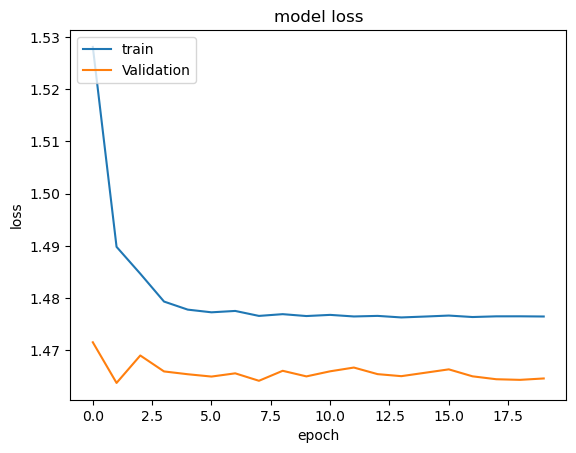

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

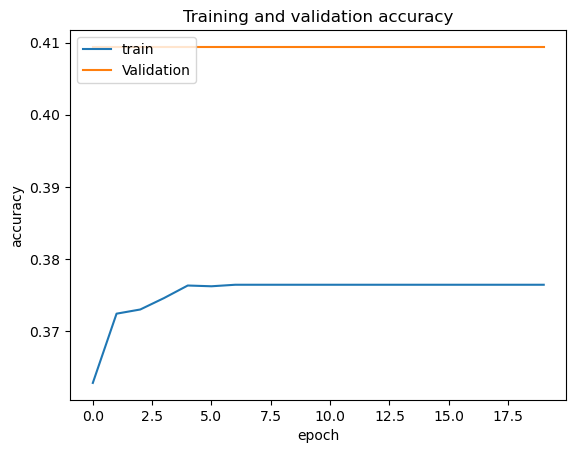

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [51]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

297/297 [==============================] - 20s 64ms/step
[[   0    2    0    0    0  965]
 [   0   22    0    0    0 2625]
 [   0    0    0    0    0  600]
 [   0    0    0    0    0  540]
 [   0    1    0    0    0 1065]
 [   0    3    0    0    0 3666]]
0.3886605543260618
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       967
           1       0.79      0.01      0.02      2647
           2       0.00      0.00      0.00       600
           3       0.00      0.00      0.00       540
           4       0.00      0.00      0.00      1066
           5       0.39      1.00      0.56      3669

    accuracy                           0.39      9489
   macro avg       0.20      0.17      0.10      9489
weighted avg       0.37      0.39      0.22      9489



<Axes: >

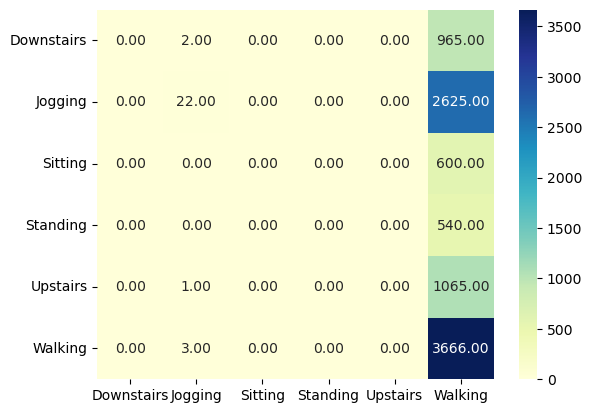

In [52]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test2 = np.argmax(y_test, axis=-1)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
cm=confusion_matrix(y_test2,y_pred)

print(cm)
print(accuracy_score(y_test2,y_pred))
print(classification_report(y_test2,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

In [53]:
# 단순히 데이터를 timestep으로 잘라서 2개의 label의 data가 겹쳤을 때 최빈값으로 데이터를 처리하는 방식은 학습시 영향을 크게 주는 것으로 해석했다.
# 다양하게 모델을 구성해도 loss가 크게 튀는 경우가 발생하기도 하고 clip을 제공하거나 lr을 낮게 줄이더라도 gradient exploding or vanishing 문제가 계속 발생했다.

# FIX
# 기존의 split_sequences를 사용했다. 이전의 참고사이트에서와의 다른 전처리가 이루어졌다.
# gradient vanishing or exploding 문제는 LSTM의 acitvation 함수를 tanh가 아닌 relu를 사용해서 나왔을 가능성이 높은 것 같다.
# 다만 Jogging과 Walking이 다른 데이터셋과 비교하여 압도적으로 많기 때문에 Walking과 Jogging으로 prediction이 쏠린 것으로 확인된다.
# data_unbalance한 문제가 존재하기 때문에 sampling기법이 필요할 것으로 보인다.


# 아래는 activityEncode별로 묶어서 segmentation하는 방법을 시도해보았다.

In [54]:
df.isnull().any()

user-id           False
activity          False
timestamp         False
X                 False
Y                 False
Z                 False
activityEncode    False
dtype: bool

In [55]:
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train[['X','Y','Z']] = scaler.fit_transform(df_train[['X','Y','Z']])

In [57]:
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098200,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098201,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098202,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [58]:
def split_sequences(sequences, time_steps, steps):
    X, y = list(), list()
    for i in range(0, len(sequences), steps):

        end_ix = i + time_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [59]:
from collections import Counter

Counter(df['activity'])

Counter({'Jogging': 342176,
         'Walking': 424397,
         'Upstairs': 122869,
         'Downstairs': 100427,
         'Sitting': 59939,
         'Standing': 48395})

In [60]:
LABEL = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

df_train_df = []
df_test_df = []

for label in LABEL:
    df_train_df.append(df_train[df_train['activity']==label])
    df_test_df.append(df_test[df_test['activity']==label])


In [61]:
X_train, y_train, X_test, y_test = [], [], [], []

for label in LABEL:
    train_sequences = df_train_df[LABEL.index(label)]
    train_sequences = np.array(train_sequences[['X','Y','Z','activityEncode']])
    test_sequences = df_test_df[LABEL.index(label)]
    test_sequences = np.array(test_sequences[['X','Y','Z','activityEncode']])

    X_train_data, y_train_label = split_sequences(train_sequences, 120, 30)
    X_test_data, y_test_label = split_sequences(test_sequences, 120, 30)

    X_train.append(X_train_data)
    y_train.append(y_train_label)
    X_test.append(X_test_data)
    y_test.append(y_test_label)

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

In [62]:
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(time_period, sensors)
print(num_classes)
print(list(label_encode.classes_))

120 3
6
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [63]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [64]:
y_train = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train.shape)

y_test = to_categorical(y_test, num_classes)
print("y_test shape: ", y_train.shape)

y_train shape:  (27094, 6)
y_test shape:  (27094, 6)


In [65]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

120 3 6


In [66]:
model = Sequential()

model.add(LSTM(64, input_shape = [n_timesteps, n_features], return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(32, 3, activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(n_outputs, activation = "softmax"))

In [67]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 120, 64)           17408     
                                                                 
 batch_normalization (Batch  (None, 120, 64)           256       
 Normalization)                                                  
                                                                 
 lstm_5 (LSTM)               (None, 120, 128)          98816     
                                                                 
 batch_normalization_1 (Bat  (None, 120, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 120, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 118, 64)          

In [68]:
from keras.callbacks import Callback, ModelCheckpoint

class TerminateOnNaN(Callback): # NaN이 된다면 해당 모델의 학습을 종료하고 이전 모델을 load하는 callback함수
    def __init__(self, model, ckptFile):
        super(TerminateOnNaN, self).__init__()
        self.model = model
        self.ckptFile = ckptFile

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        if loss is not None and np.isnan(loss):
            print(f"Epoch {epoch + 1}: Loss is NaN. Restoring previous model.")
            self.model.stop_training = True
            self.model.load_weights(self.ckptFile)

ckptFile = 'WISDM_LSTM.pth'
ckptCallback = ModelCheckpoint(filepath=ckptFile, save_best_only=True)

In [69]:
# history = model.fit(X_train, y_train, batch_size= 256, epochs=50, validation_split=0.2, verbose=True
#                     , callbacks=[TerminateOnNaN(model, ckptFile), ckptCallback])
history = model.fit(X_train, y_train, batch_size= 256, epochs=30, verbose=True, validation_split=0.3)

Epoch 1/30
75/75 [==============================] - 116s 1s/step - loss: 1.3597 - accuracy: 0.5186 - val_loss: 1.4903 - val_accuracy: 1.0000
Epoch 2/30
75/75 [==============================] - 125s 2s/step - loss: 0.8140 - accuracy: 0.6605 - val_loss: 1.2977 - val_accuracy: 1.0000
Epoch 3/30
75/75 [==============================] - 113s 2s/step - loss: 0.6965 - accuracy: 0.7183 - val_loss: 1.0264 - val_accuracy: 1.0000
Epoch 4/30
75/75 [==============================] - 106s 1s/step - loss: 0.5390 - accuracy: 0.7915 - val_loss: 2.6203 - val_accuracy: 0.1482
Epoch 5/30
75/75 [==============================] - 110s 1s/step - loss: 0.3483 - accuracy: 0.8855 - val_loss: 6.6810 - val_accuracy: 0.0016
Epoch 6/30
75/75 [==============================] - 110s 1s/step - loss: 0.2089 - accuracy: 0.9353 - val_loss: 0.3647 - val_accuracy: 0.9793
Epoch 7/30
75/75 [==============================] - 109s 1s/step - loss: 0.1702 - accuracy: 0.9486 - val_loss: 0.1588 - val_accuracy: 0.9895
Epoch 8/30
75

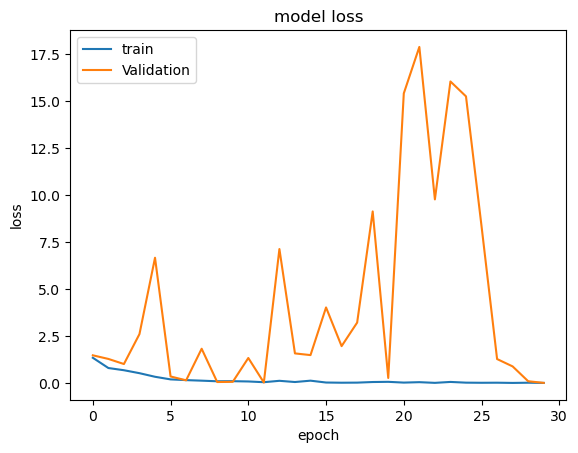

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

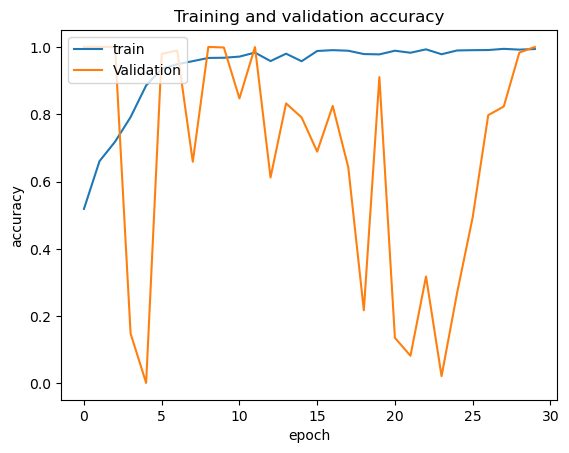

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [72]:
# from keras.models import load_model
# model = load_model('WISDM_LSTM.pth')

In [73]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print("Accuracy of the LSTM_CNN model", test_accuracy)
predictions = model.predict(X_test)

Accuracy of the LSTM_CNN model 0.3028927445411682
296/296 [==============================] - 25s 80ms/step


In [74]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[  54  458    0    0   34  417]
 [   1 2591    0    0    0   55]
 [   0  138    1    0   68  390]
 [   3    7    0   18   33  477]
 [  39  606    0    0   24  393]
 [  69 3401    0    0   14  181]]
**** Classification Report ****
              precision    recall  f1-score   support

  Downstairs       0.33      0.06      0.10       963
     Jogging       0.36      0.98      0.53      2647
     Sitting       1.00      0.00      0.00       597
    Standing       1.00      0.03      0.06       538
    Upstairs       0.14      0.02      0.04      1062
     Walking       0.09      0.05      0.06      3665

    accuracy                           0.30      9472
   macro avg       0.49      0.19      0.13      9472
weighted avg       0.31      0.30      0.19      9472



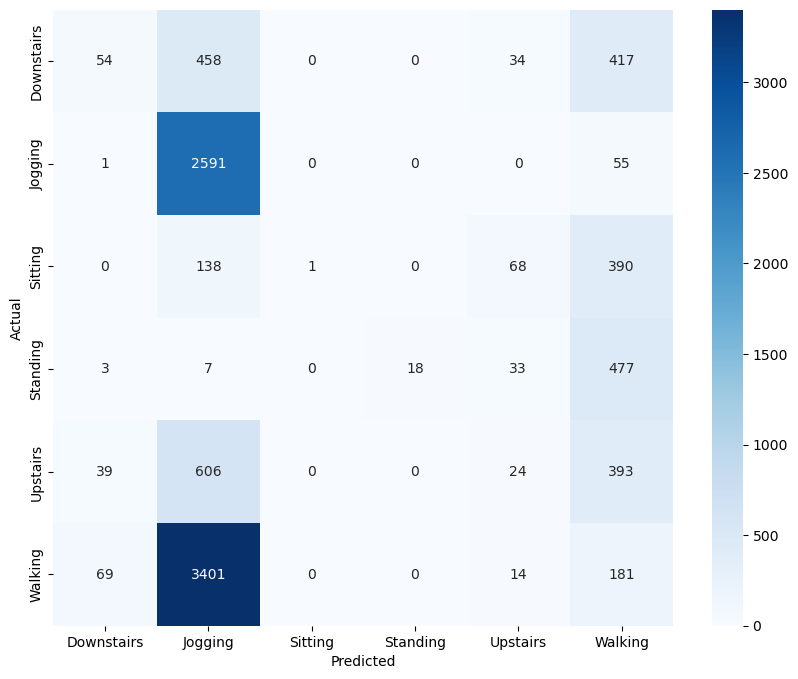

In [75]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
display_results(y_test,predictions, LABELS)


In [ ]:
# acivityEncode별로 처리하는 방식은 accuarcy를 높일수는 없었지만 어느정도 prediction이 치우치는 것을 방지할 수 있었다.
# 하지만 여전히 jogging과 Walking에 prediction이 치우쳐져있는 것을 확인할 수 있었다.

In [275]:
#3. Data의 segmentation 문제의 영향이 크지 않았던 것으로 나왔고 다음 가정은 data unbalance 문제이다.
# sampling기법중 downsampling를 사용할 예정이다.
# upsampling을 하기에는 데이터의 갯수의 차이가 너무 많이 나서 크게 upsampling된 label이 overfitting의 가능성이 높다.
# downsampling을 사용하되 자를 때 이동하는 steps를 작게 줘서 겹치는 부분이 크게 만들 예정이다.
# 만약 steps를 크게 가져가서 겹치는 부분이 작아진다면 문제가 발생할 것이다.
# => downsampling을 했는데 우연히 가장 중요한 부분이 빠지는 부분이 존재할 수 있다.
# 이를 겹치는 부분을 최대한 만들어서 downsampling을 하더라도 중요한 부분이 유지될 수 있도록 한다.

In [28]:
from keras import regularizers

In [7]:
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_train[['X','Y','Z']] = scaler.fit_transform(df_train[['X','Y','Z']])

In [9]:
def split_sequences(sequences, time_steps, steps=1):
    X, y = list(), list()
    for i in range(0, len(sequences), steps):

        end_ix = i + time_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
from collections import Counter

Counter(df['activity'])

Counter({'Jogging': 342176,
         'Walking': 424397,
         'Upstairs': 122869,
         'Downstairs': 100427,
         'Sitting': 59939,
         'Standing': 48395})

In [11]:
LABEL = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIMESTEPS , NSTEPS = 150, 30

df_train_df = []
df_test_df = []

minNum = float("inf");

for label in LABEL:
    df_train_df.append(df_train[df_train['activity']==label])
    df_test_df.append(df_test[df_test['activity']==label])
    if df_train[df_train['activity']==label].size < minNum:
        minNum = df_train[df_train['activity']==label].size

num_chunks = (minNum - TIMESTEPS) // NSTEPS + 1;  
# label중 가장 적은 수의 데이터를 가지고 있는 label의 수를 저장한다.
# Timesteps와 Nsteps로 잘랐을 때 해당 label이 가질 수 있는 최대 batch_size수를 계산한다.


In [12]:
X_train, y_train, X_test, y_test = [], [], [], []

for label in LABEL:
    train_sequences = df_train_df[LABEL.index(label)]
    train_sequences = np.array(train_sequences[['X','Y','Z','activityEncode']])
    test_sequences = df_test_df[LABEL.index(label)]
    test_sequences = np.array(test_sequences[['X','Y','Z','activityEncode']])

    X_train_data, y_train_label = split_sequences(train_sequences, TIMESTEPS, NSTEPS)
    X_test_data, y_test_label = split_sequences(test_sequences, TIMESTEPS, NSTEPS)

    idx = np.random.choice(len(X_train_data), num_chunks)

    X_train.append(X_train_data[idx])
    y_train.append(y_train_label[idx])
    X_test.append(X_test_data)
    y_test.append(y_test_label)

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)

In [13]:
X_train.shape

(44994, 150, 3)

In [14]:
y_train

array([0., 0., 0., ..., 5., 5., 5.])

In [15]:
time_period, sensors = X_train.shape[1], X_train.shape[2]
num_classes = label_encode.classes_.size
print(time_period, sensors)
print(num_classes)
print(list(label_encode.classes_))

150 3
6
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [16]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [17]:
y_train = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train.shape)

y_test = to_categorical(y_test, num_classes)
print("y_test shape: ", y_train.shape)

y_train shape:  (44994, 6)
y_test shape:  (44994, 6)


In [18]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

150 3 6


In [40]:
model = Sequential()

model.add(LSTM(32, input_shape = [n_timesteps, n_features], return_sequences=True, recurrent_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(LSTM(32, return_sequences=True, recurrent_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(16, 3, activation='relu'))
model.add(MaxPool1D())
model.add(Conv1D(8, 3, activation="relu"))
model.add(MaxPool1D())
model.add(Dropout(0.4))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation = "softmax"))

In [41]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 150, 32)           4608      
                                                                 
 batch_normalization_14 (Ba  (None, 150, 32)           128       
 tchNormalization)                                               
                                                                 
 lstm_15 (LSTM)              (None, 150, 32)           8320      
                                                                 
 batch_normalization_15 (Ba  (None, 150, 32)           128       
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 150, 32)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 148, 16)          

In [42]:
history = model.fit(X_train, y_train, batch_size= 512, epochs=30, verbose=True, validation_split=0.3)

Epoch 1/30
62/62 [==============================] - 77s 1s/step - loss: 1.0133 - accuracy: 0.6480 - val_loss: 3.2875 - val_accuracy: 0.0000e+00
Epoch 2/30
62/62 [==============================] - 62s 998ms/step - loss: 0.3954 - accuracy: 0.9000 - val_loss: 3.8751 - val_accuracy: 0.0000e+00
Epoch 3/30
62/62 [==============================] - 62s 998ms/step - loss: 0.2685 - accuracy: 0.9264 - val_loss: 8.5686 - val_accuracy: 0.0000e+00
Epoch 4/30
62/62 [==============================] - 59s 946ms/step - loss: 0.2209 - accuracy: 0.9332 - val_loss: 15.1274 - val_accuracy: 2.2224e-04
Epoch 5/30
62/62 [==============================] - 59s 956ms/step - loss: 0.1777 - accuracy: 0.9465 - val_loss: 12.5800 - val_accuracy: 0.1428
Epoch 6/30
62/62 [==============================] - 59s 952ms/step - loss: 0.1602 - accuracy: 0.9549 - val_loss: 11.4678 - val_accuracy: 0.0658
Epoch 7/30
62/62 [==============================] - 59s 953ms/step - loss: 0.1582 - accuracy: 0.9552 - val_loss: 13.7137 - val

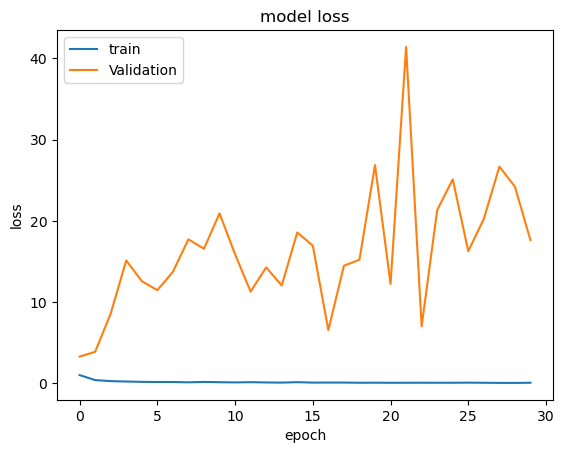

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

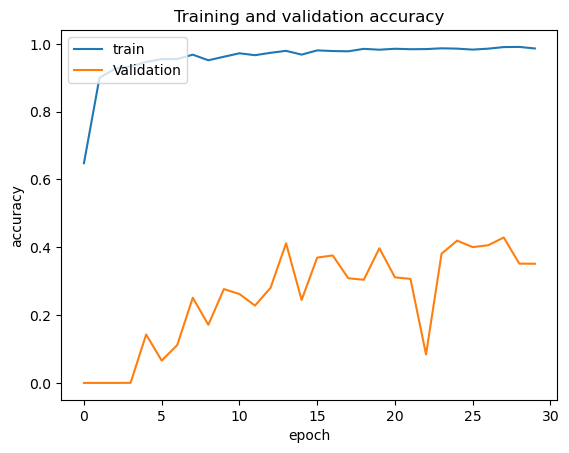

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print("Accuracy of the LSTM_CNN model", test_accuracy)
predictions = model.predict(X_test)

Accuracy of the LSTM_CNN model 0.3154447376728058
296/296 [==============================] - 13s 38ms/step


In [46]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[ 201  411  244    0  106    0]
 [  73 2573    0    0    0    0]
 [ 100  207  118    0  171    0]
 [ 121    0  416    0    0    0]
 [ 393  391  183    0   94    0]
 [ 641 1919  923    0  181    0]]
**** Classification Report ****
              precision    recall  f1-score   support

  Downstairs       0.13      0.21      0.16       962
     Jogging       0.47      0.97      0.63      2646
     Sitting       0.06      0.20      0.10       596
    Standing       0.00      0.00      0.00       537
    Upstairs       0.17      0.09      0.12      1061
     Walking       0.00      0.00      0.00      3664

    accuracy                           0.32      9466
   macro avg       0.14      0.24      0.17      9466
weighted avg       0.17      0.32      0.21      9466



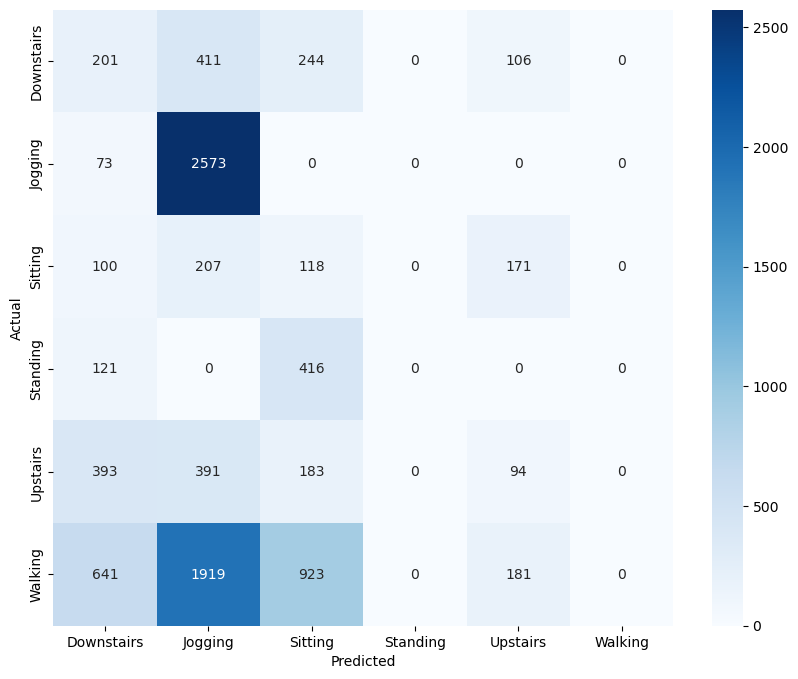

In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
display_results(y_test,predictions, LABELS)

In [ ]:
# prediction의 분포는 고르게 나타났으나 이번에는 오히려 Walking에 대한 prediction이 모두 jogging에 쏠리는 문제가 발생했다.
# steps를 작게 조정했음에도 Walking에 대한 주요한 정보가 downsampling과정에서 누락되었거나
# jogging과 Walking의 유사성으로 인해 구분을 잘 못하는 것 같다.